## Install Packages

In [1]:
!pip install pyLDAvis
!pip install mallet
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.25.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for mallet: filename=Mallet-0.1.5-py3-none-any.whl size=5690 sha256=64f7fcf488edffc2cd8b10a4564c4f2c923c31632bd782ad7909819c92174975
  Stored in directory: /root/.cache/pip/wheels/56/df

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import mallet
import os
import re
import nltk

In [2]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
# from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

In [4]:
df = pd.read_csv("tweets_v172_final_final_final.csv")

In [5]:
# df = df[~df['job'].isna()]

In [6]:
keep_list = ['school','college','university','education','student','teacher'#,'learning'
             ,'curriculum','class','exam','homework','teaching','academia','academic']
pat = '|'.join(r"\b{}\b".format(x) for x in keep_list)
df = df[df['text'].str.contains(pat, case=False)] #\b to avoid match cat in words bobcat is nice, matching cat is nice

In [ ]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_row', 100)

In [ ]:
df.shape

(8198, 20)

In [7]:
df.rename(columns = {'text':'Tweet'}, inplace = True)

In [8]:
#Remove URL from tweet text
df['Text'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+', '',x))
#Remove mention (@user)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\S+', '',x))
#Remove hashtag (#hashtag)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'#\S+', '',x))
#All lowercases
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
#Remove Punctuation
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [9]:
df = df.drop_duplicates(subset=['Text'], keep='first')

In [ ]:
df.Text[0]

'read aigenerated academic science writing can be identified with over 99 accuracy for more get the app from'

In [ ]:
df.Tweet[0]

'Read "AI-generated academic science writing can be identified with over 99% accuracy" https://t.co/qZcnOWEEqj\n\nFor more, get the app from\nhttps://t.co/0ic5ya66on\n\n#LLM #GPT #AI #ML #DL #ChatGPT #research #GenAI https://t.co/aYrXTQFq6P'

In [10]:
#Replace 'chat gpt' with 'chatgpt'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))
#Replace 'machine learning' with 'machinelearning'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'machine learning', 'machinelearning', x))
#Replace 'deep learning' with 'deeplearning'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'deep learning', 'deeplearning', x))

### Removing stop words, Tokenization

In [11]:
nltk.download('all')
#remove stopwords, short tokens, and accents
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [12]:
stopwords.sort()
stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [13]:
stopwords.extend(['amp', 'like', 'though'])
len(stopwords)
#simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
df['Token'] = df['Text'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True) if word not in stopwords])

### N-Gram

In [14]:
#Build the bigram and trigrams
bigram = Phrases(df['Token'], min_count=37, threshold=100)
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram[df['Token']]
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [15]:
trigram = Phrases(df['Bigram'], min_count=37, threshold=100)
df['Trigram'] = trigram[df['Bigram']]
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Inspecting

In [ ]:
df[df['Trigram']!=df['Bigram']][0:50]

In [ ]:
# Get the bigram and trigram phrases
biphrase = bigram.export_phrases()
triphrase = trigram.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

Bi:9, Tri:9


In [ ]:
biphrase, triphrase

({'artificial_intelligence': 308.182242108074,
  'game_changer': 203.18600174978127,
  'language_model': 102.39011238641798,
  'computer_science': 116.89565117349287,
  'language_models': 100.99057558507273,
  'large_language': 127.53741213466519,
  'critical_thinking': 136.85070711211313,
  'medical_licensing': 296.4409544490978,
  'blog_post': 192.57180762852406},
 {'artificial_intelligence': 65766.425,
  'language_model': 219.15063157894738,
  'computer_science': 327.1945293644409,
  'large_language': 780.9193548387098,
  'large_language_models': 684.8062034739455,
  'critical_thinking': 390.5053185271771,
  'medical_licensing': 6007.763874345549,
  'us_medical_licensing': 894.5076246334312,
  'blog_post': 643.7207977207977})

In [ ]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram.vocab
trigram_vocab = trigram.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common bigrams and trigrams
print("Top 20 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

print("\nTop 20 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

Top 20 most common bigrams:
united_states: 720.2721088435375
medical_licensing: 386.18844984802433
game_changer: 353.86949602122013
trillion_ml: 346.1461538461539
artificial_intelligence: 271.39170390014704
blog_post: 225.42886110172356
critical_thinking: 217.14334543900875
social_media: 168.7534411977783
looking_forward: 157.71847414880202
times_powerful: 147.2113347457627
current_version: 133.49724192277384
ml_parameters: 127.75867269984917
natural_language: 122.07292077256602
computer_science: 117.35467980295567
next_week: 116.48723309456079
gpt_billion: 113.47779488758854
language_processing: 112.86754304017083
academic_integrity: 112.2691693975945
licensing_exam: 109.16306908136077
prompt_engineering: 108.46052208338489

Top 20 most common trigrams:
united_states: 136288.57142857142
medical_licensing: 45291.85858585859
artificial_intelligence: 33400.84195605953
us_medical_licensing: 5518.246941045606
natural_language_processing: 3282.6494623655913
trillion_ml: 1980.261294261294
bu

#### Apply

In [16]:
import time

# bi-gram and tri-gram implementation
start_time = time.time()
df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken1: {total_time:.2f} seconds")

start_time = time.time()
df['Token']= df['Token'].apply(lambda x:trigram_mod[bigram_mod[x]])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken2: {total_time:.2f} seconds")

Total time taken1: 0.12 seconds
Total time taken2: 0.38 seconds


### Lemmatization

In [17]:
#Lemmatization
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#define a function to map POS tags from treebank tag into wordnet tags
wnl = WordNetLemmatizer()
def get_wordnet(pos):
    if pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     #default to noun if no match


# Define a function to tag and lemmatize a text string
def lemmatizer(text):
    pos_tags = pos_tag(text)
    text = [wnl.lemmatize(word, pos = get_wordnet(pos)) for word, pos in pos_tags]
    return text

start_time = time.time()

df['Lemmatized'] = df['Token'].apply(lambda x: lemmatizer(x))

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 12.01 seconds


In [18]:
# remove stopwords and short tokens again after lemmatization
df['Text_new'] = df['Lemmatized'].apply(lambda x: ' '.join(x))
df['Tokens'] = df['Text_new'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True, min_len=3, max_len=50) if word not in stopwords])

## Cluster text with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['Text_new'])

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0, 'Number of clusters')

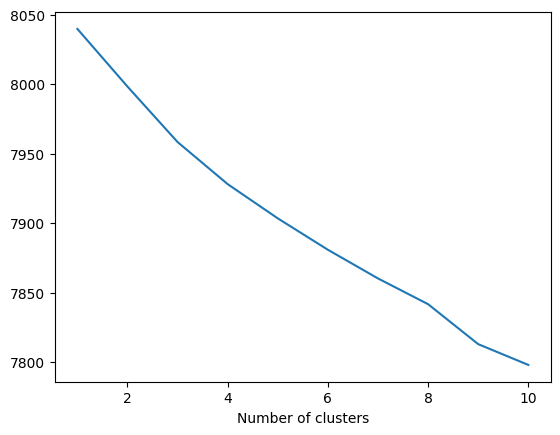

In [ ]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')

In [ ]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=6, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [ ]:
df['job_clusters'] = clusters

In [ ]:
from google.colab import files

for i in range(0, 6):
  df[df['job_clusters']==i][['job']].value_counts().to_csv('job' + str(i) + '.csv', index=True)
  files.download('job' + str(i) + '.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Sentiment Analysis Graph


In [ ]:
df['sentiment_text'] = np.where(df["sentiment"] == 0, 'Negative', np.where(df["sentiment"] == 1, 'Neutral', 'Positive'))
count = df.groupby(['sentiment_text']).size()

In [ ]:
percent = [(x / total) * 100 for x in performance]

NameError: name 'performance' is not defined

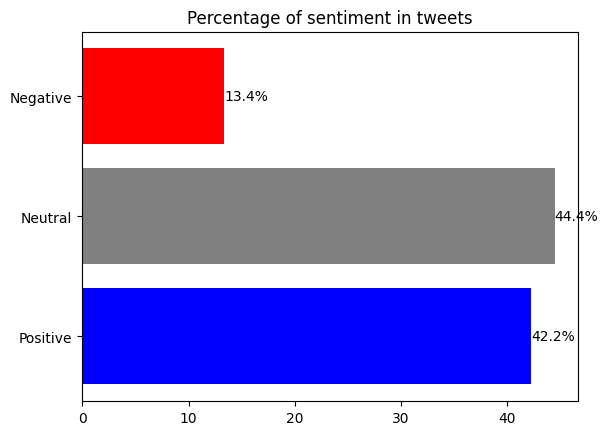

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = count.index.tolist()
y_pos = np.arange(len(people))

performance = count.tolist()
# Totals to produce a composition ratio
total = sum(performance)
percent = [(x / total) * 100 for x in performance]

c = ['red', 'gray', 'blue']

ax.barh(y_pos, percent,  align='center', color = c)
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
# add values above bars
ax.bar_label(ax.containers[0], fmt='%.1f%%');
ax.set_title('Percentage of sentiment in tweets')

plt.show()

### Plot sentiment count over time

In [ ]:
from datetime import datetime

tmp = df[['date', 'sentiment_text']].copy()
tmp['date'] = pd.to_datetime(tmp['date'])

In [ ]:
#tmp['year_week'] = tmp.date.dt.strftime('%Y-%W')
tmp['year_week'] = tmp.date.dt.strftime('%Y-%U')
tmp['month_year'] = tmp.date.dt.strftime('%b %Y')

In [ ]:
tmp2 = tmp[['year_week', 'sentiment_text', 'month_year']]
tmp = tmp[['year_week', 'sentiment_text']]

In [ ]:
# reset_index() gives a column for counting, after groupby uses year and category
ctdf = (tmp.reset_index()
          .groupby(['year_week','sentiment_text'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

In [ ]:
def getMonth(year_week):
    """Return the month number in the given week in the given year."""
    year = int(year_week[:4])
    week = int(year_week[5:])
    return datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w")

ctdf['month_year'] = ctdf['year_week'].apply(getMonth)
ctdf['month_year'] = pd.to_datetime(ctdf['month_year']).dt.strftime('%b %Y')

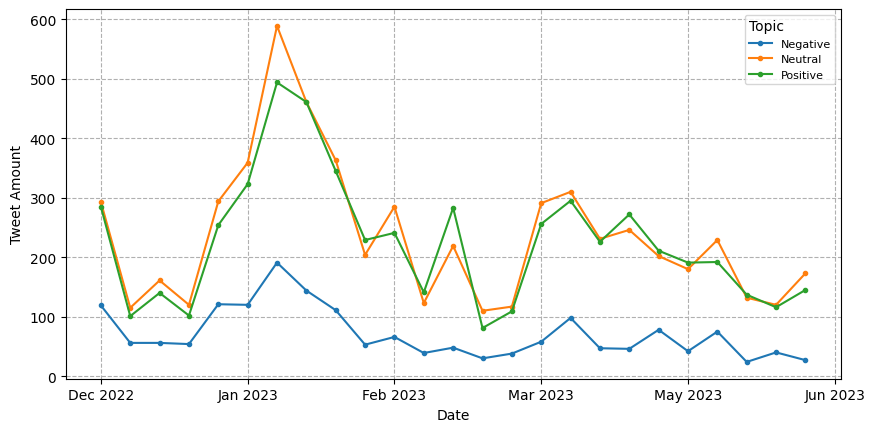

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_figwidth(10)

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('sentiment_text'):
    data.plot(x='year_week', y='ct', marker='.', ax=ax, label=key)

str_month_list = ['padding','Dec 2022','Jan 2023','Feb 2023','Mar 2023','May 2023','Jun 2023','padding']
ax.set_xticklabels(str_month_list)

plt.xlabel('Date')
plt.ylabel('Tweet Amount')
plt.grid(linestyle='--')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0, 1, 2]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           title='Topic', bbox_to_anchor=(1, 1), fontsize="8", title_fontsize="10")._legend_box.align = "left"

## WordCloud

In [ ]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [ ]:
temp = df['Token'].apply(lambda x: ' '.join(x))

In [ ]:
temp = ' '.join(temp)

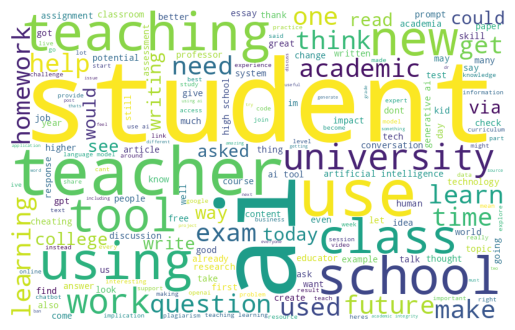

In [ ]:
wc = WordCloud(background_color='white', stopwords = ['chatgpt', 'education'], width = 800, height = 500).generate(temp)
plt.axis("off")
plt.imshow(wc)

In [ ]:
from collections import Counter
Counter(temp.split()).most_common()

[('chatgpt', 3494),
 ('ai', 3281),
 ('education', 3211),
 ('students', 1682),
 ('use', 1587),
 ('school', 1384),
 ('teaching', 1208),
 ('student', 1208),
 ('using', 1129),
 ('learning', 1084),
 ('exam', 1056),
 ('academic', 1012),
 ('new', 993),
 ('university', 881),
 ('class', 856),
 ('writing', 691),
 ('us', 682),
 ('help', 679),
 ('write', 673),
 ('teachers', 643),
 ('teacher', 635),
 ('homework', 621),
 ('college', 604),
 ('future', 602),
 ('tools', 601),
 ('work', 550),
 ('learn', 547),
 ('time', 541),
 ('tool', 539),
 ('used', 526),
 ('get', 515),
 ('questions', 510),
 ('impact', 501),
 ('need', 501),
 ('read', 496),
 ('technology', 493),
 ('could', 488),
 ('think', 481),
 ('one', 480),
 ('asked', 458),
 ('make', 446),
 ('im', 437),
 ('see', 433),
 ('good', 427),
 ('research', 423),
 ('potential', 423),
 ('know', 419),
 ('would', 419),
 ('via', 409),
 ('world', 409),
 ('language', 408),
 ('way', 407),
 ('intelligence', 403),
 ('dont', 392),
 ('today', 384),
 ('going', 384),
 ('ar

### For each sentiment

In [ ]:
# Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive
sentiment = df[df['sentiment']==1]

In [ ]:
temp = sentiment['Token'].apply(lambda x: ' '.join(x))

In [ ]:
temp = ' '.join(temp)

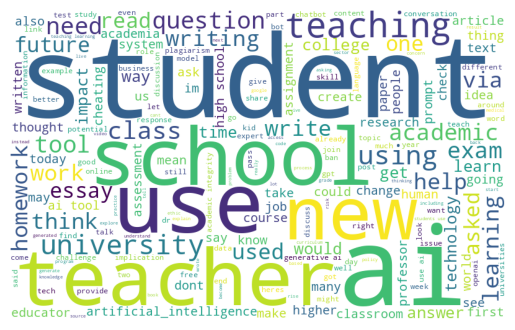

In [ ]:
wc = WordCloud(background_color='white', stopwords = ['chatgpt', 'education'], width = 800, height = 500).generate(temp)
plt.axis("off")
plt.imshow(wc)

In [ ]:
from collections import Counter
Counter(temp.split()).most_common()

[('chatgpt', 3494),
 ('ai', 3281),
 ('education', 3211),
 ('students', 1682),
 ('use', 1587),
 ('school', 1384),
 ('teaching', 1208),
 ('student', 1208),
 ('using', 1129),
 ('learning', 1084),
 ('exam', 1056),
 ('academic', 1012),
 ('new', 993),
 ('university', 881),
 ('class', 856),
 ('writing', 691),
 ('us', 682),
 ('help', 679),
 ('write', 673),
 ('teachers', 643),
 ('teacher', 635),
 ('homework', 621),
 ('college', 604),
 ('future', 602),
 ('tools', 601),
 ('work', 550),
 ('learn', 547),
 ('time', 541),
 ('tool', 539),
 ('used', 526),
 ('get', 515),
 ('questions', 510),
 ('impact', 501),
 ('need', 501),
 ('read', 496),
 ('technology', 493),
 ('could', 488),
 ('think', 481),
 ('one', 480),
 ('asked', 458),
 ('make', 446),
 ('im', 437),
 ('see', 433),
 ('good', 427),
 ('research', 423),
 ('potential', 423),
 ('know', 419),
 ('would', 419),
 ('via', 409),
 ('world', 409),
 ('language', 408),
 ('way', 407),
 ('intelligence', 403),
 ('dont', 392),
 ('today', 384),
 ('going', 384),
 ('ar

## Create the Dictionary and Corpus

In [ ]:
df.Tokens.describe()

count                 8198
unique                8149
top       [episode, focus]
freq                     5
Name: Tokens, dtype: object

### Dictionary

In [19]:
import ast
# # convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(str(x)))

In [20]:
dictionary = Dictionary(df['Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 11153


In [21]:
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

In [22]:
#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

In [23]:
# Top 10 high-frequency words
df_dict.sort_values('frequency', ascending = False).head(20)

,frequency
use,2094
chatgpt,2059
education,2027
student,1913
write,1040
school,996
teach,881
learn,873
teacher,829
tool,716


In [24]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5)  #words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 1506


In [ ]:
# remove unwanted word from the dictionary in place
# bad_ids = [dictionary.token2id[t] for t in ['amp']]
# dictionary.filter_tokens(bad_ids=bad_ids)
# print(f'Total vocabulary size: {len(dictionary)}')

### Corpus

In [25]:
# Recreate the corpus for LDA model
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

In [26]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(20)

,frequency
use,2094
chatgpt,2059
education,2027
student,1913
write,1040
school,996
teach,881
learn,873
teacher,829
tool,716


In [27]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Tokens'][0:1000]]

In [ ]:
len(corpus),len(dictionary)

(13339, 2115)

## LDA Model Implementation

In [28]:
import time
import logging
from tqdm import tqdm

In [29]:
num_topics = 6
passes = 10
total_iteration = num_topics*passes
alpha = 0.31
beta = 0.91

In [30]:
start_time =time.time()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# train the LdaModel
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=beta, passes=passes, random_state=42)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 33.33 seconds


In [38]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('education', 0.09485823),
   ('chatgpt', 0.026509643),
   ('future', 0.017749462),
   ('learn', 0.016533688),
   ('change', 0.01597323),
   ('technology', 0.014587454),
   ('new', 0.014485079),
   ('impact', 0.014388707),
   ('world', 0.013220836),
   ('conversation', 0.011829356)]),
 (1,
  [('student', 0.043362293),
   ('teach', 0.04053501),
   ('ask', 0.023550589),
   ('learn', 0.018478043),
   ('use', 0.017125638),
   ('answer', 0.014913714),
   ('question', 0.014420469),
   ('write', 0.01098723),
   ('response', 0.010007128),
   ('create', 0.00952727)]),
 (2,
  [('school', 0.036816586),
   ('use', 0.031057097),
   ('homework', 0.030155217),
   ('student', 0.023432888),
   ('make', 0.02182059),
   ('teacher', 0.020280195),
   ('chatgpt', 0.019267304),
   ('say', 0.016768305),
   ('think', 0.015411652),
   ('dont', 0.013572903)]),
 (3,
  [('write', 0.049178593),
   ('student', 0.038729202),
   ('academic', 0.036854453),
   ('use', 0.027960444),
   ('essay', 0.027175445),
   

In [31]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence = cm.get_coherence()

In [32]:
print(f'Coherence score: {coherence}')

Coherence score: 0.4041826140306022


In [ ]:
import pickle
#save the model
pickle.dump(lda_model, open('ldamodel.pkl', 'wb'))

### t-SNE

In [ ]:
# LDA, tSNE
from sklearn.manifold import TSNE
from gensim.models.ldamodel import LdaModel
# Visualization
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=beta, passes=passes, random_state=42, minimum_probability=0)

In [ ]:
hm = np.array([[y for (x,y) in lda_model[corpus[i]]] for i in range(len(corpus))])

In [ ]:
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
X_tsne = tsne.fit_transform(hm)

In [ ]:
#get the topic distribution for each tweets
topic_dist = [lda_model[doc] for doc in corpus]
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]

y_train = [topic+1 for topic in dominant_topic]

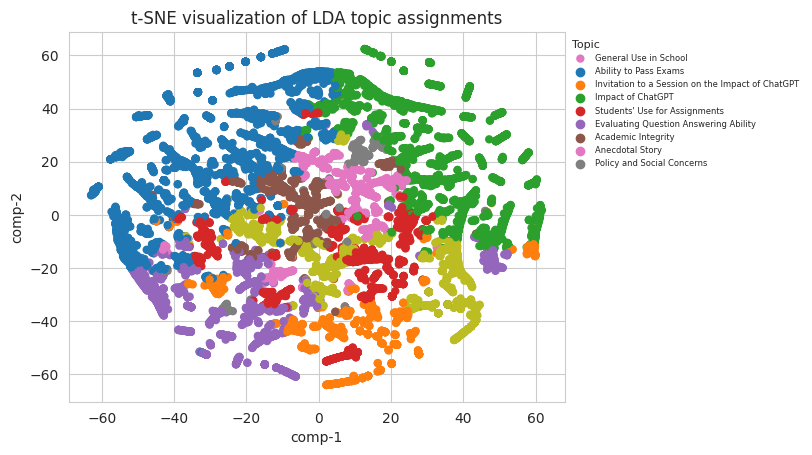

In [ ]:
tmp = pd.DataFrame()
tmp["y"] = y_train
tmp["comp-1"] = X_tsne[:,0]
tmp["comp-2"] = X_tsne[:,1]

sns.set_style("whitegrid")
sns.scatterplot(x="comp-1", y="comp-2", hue=tmp.y.tolist(),
                palette=sns.color_palette(n_colors=9), linewidth=0,
                data=tmp).set(title="t-SNE visualization of LDA topic assignments")
leg = plt.legend(title='Topic', bbox_to_anchor=(1, 1), fontsize="6", title_fontsize="8", frameon=False,
                                                    labels=['General Use in School', 'Ability to Pass Exams', 'Invitation to a Session on the Impact of ChatGPT',
                                                            'Impact of ChatGPT', "Students' Use for Assignments", "Evaluating Question Answering Ability",
                                                            'Academic Integrity', 'Anecdotal Story', 'Policy and Social Concerns'])
leg._legend_box.align = "left"

In [ ]:
import plotly.express as px

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y_train)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [ ]:
from matplotlib.lines import Line2D

from gensim.models import LdaModel
from gensim import corpora
from sklearn.manifold import TSNE
# %matplotlib notebook # if in Jupyter for rotating and zooming

In [ ]:
def LDA_tSNE_topics_vis(dimension='both',
                        dirichlet_model=None,
                        corpus=None,
                        num_topics=10,
                        remove_3d_outliers=False,
                        save_png=False):
    """
    Returns the outputs of an LDA model plotted using t-SNE (t-distributed Stochastic Neighbor Embedding)

    Note: t-SNE reduces the dimensionality of a space such that similar points will be closer and dissimilar points farther

    Parameters
    ----------
        dimension : str (default=both)
            The dimension that t-SNE should reduce the data to for visualization
            Options: 2d, 3d, and both (a plot with two subplots)

        corpus : list, list of lists
            The tokenized and cleaned text corpus over which analysis should be done

        num_topics : int (default=10)
            The number of categories for LDA based approaches

        remove_3d_outliers : bool (default=False)
            Whether to remove outliers from a 3d plot

        save_png : bool (default=False)
            Whether to save the figure as a png

    Returns
    -------
        A t-SNE lower dimensional representation of an LDA model's topics and their constituent members
    """
    bow_corpus = corpus
    dirichlet_model = lda_model

    df_topic_coherences = pd.DataFrame(columns = ['topic_{}'.format(i) for i in range(num_topics)])

    for i in range(len(bow_corpus)):
        df_topic_coherences.loc[i] = [0] * num_topics

        output = dirichlet_model.__getitem__(bow=bow_corpus[i], eps=0)

        for j in range(len(output)):
            topic_num = output[j][0]
            coherence = output[j][1]
            df_topic_coherences.iloc[i, topic_num] = coherence

    for i in range(num_topics):
        df_topic_coherences.iloc[:, i] = df_topic_coherences.iloc[:, i].astype('float64', copy=False)

    df_topic_coherences['main_topic'] = df_topic_coherences.iloc[:, :num_topics].idxmax(axis=1)

    if num_topics > 10:
        # cubehelix better for more than 10 colors
        colors = sns.color_palette("cubehelix", num_topics)
    else:
        # The default sns color palette
        colors = sns.color_palette('deep', num_topics)

    tsne_2 = None
    tsne_3 = None
    if dimension == 'both':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    elif dimension == '2d':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
    elif dimension == '3d':
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    else:
        ValueError("An invalid value has been passed to the 'dimension' argument - choose from 2d, 3d, or both.")

    if tsne_2 is not None:
        tsne_results_2 = tsne_2.fit_transform(df_topic_coherences.iloc[:, :num_topics])

        df_tsne_2 = pd.DataFrame()
        df_tsne_2['tsne-2d-d1'] = tsne_results_2[:,0]
        df_tsne_2['tsne-2d-d2'] = tsne_results_2[:,1]
        df_tsne_2['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_2['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_2['main_topic']]

        df_tsne_2['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_2['main_topic']]
        df_tsne_2 = df_tsne_2.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)

    if tsne_3 is not None:
        colors = [c for c in sns.color_palette()]

        tsne_results_3 = tsne_3.fit_transform(df_topic_coherences.iloc[:, :num_topics])

        df_tsne_3 = pd.DataFrame()
        df_tsne_3['tsne-3d-d1'] = tsne_results_3[:,0]
        df_tsne_3['tsne-3d-d2'] = tsne_results_3[:,1]
        df_tsne_3['tsne-3d-d3'] = tsne_results_3[:,2]
        df_tsne_3['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_3['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_3['main_topic']]

        df_tsne_3['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_3['main_topic']]
        df_tsne_3 = df_tsne_3.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)

        if remove_3d_outliers:
            # Remove those rows with values that are more than three standard deviations from the column mean
            for col in ['tsne-3d-d1', 'tsne-3d-d2', 'tsne-3d-d3']:
                df_tsne_3 = df_tsne_3[np.abs(df_tsne_3[col] - df_tsne_3[col].mean()) <= (3 * df_tsne_3[col].std())]

    if tsne_2 is not None and tsne_3 is not None:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, # pylint: disable=unused-variable
                                       figsize=(20,10))
        ax1.axis('off')

    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

    if tsne_2 is not None and tsne_3 is not None:
        # Plot tsne_2, with tsne_3 being added later
        ax1 = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                              hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)

        light_grey_tup = (242/256, 242/256, 242/256)
        ax1.set_facecolor(light_grey_tup)
        ax1.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax1.set_xlabel('tsne-d1', fontsize=20)
        ax1.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax1.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax1.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order],
                   facecolor=light_grey_tup)

    elif tsne_2 is not None:
        # Plot just tsne_2
        ax = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                             hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)

        ax.set_facecolor(light_grey_tup)
        ax.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order],
                  facecolor=light_grey_tup)

    if tsne_2 is not None and tsne_3 is not None:
        # tsne_2 has been plotted, so add tsne_3
        ax2 = fig.add_subplot(121, projection='3d')
        ax2.scatter(xs=df_tsne_3['tsne-3d-d1'],
                    ys=df_tsne_3['tsne-3d-d2'],
                    zs=df_tsne_3['tsne-3d-d3'],
                    c=df_tsne_3['color'],
                    alpha=0.3)

        ax2.set_facecolor('white')
        ax2.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax2.set_xlabel('tsne-d1', fontsize=20)
        ax2.set_ylabel('tsne-d2', fontsize=20)
        ax2.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines and order their colors to match tsne_2
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in legend_order]
            ax2.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)],
                       loc='upper left', facecolor=(light_grey_tup))

    elif tsne_3 is not None:
        # Plot just tsne_3
        ax.axis('off')
        ax.set_facecolor('white')
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=df_tsne_3['tsne-3d-d1'],
                   ys=df_tsne_3['tsne-3d-d2'],
                   zs=df_tsne_3['tsne-3d-d3'],
                   c=df_tsne_3['color'],
                   alpha=0.3)

        ax.set_facecolor('white')
        ax.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)
        ax.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in range(len(colors))]
            ax.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)],
                      loc='upper left', facecolor=light_grey_tup)

    if save_png:
        plt.savefig('LDA_tSNE_{}.png'.format(time.strftime("%Y%m%d-%H%M%S")), bbox_inches='tight', dpi=500)

    plt.show()

<ipython-input-54-77dd5b2ef5ba>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1383642852306366' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_topic_coherences.iloc[i, topic_num] = coherence
<ipython-input-54-77dd5b2ef5ba>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.01647583767771721' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_topic_coherences.iloc[i, topic_num] = coherence
<ipython-input-54-77dd5b2ef5ba>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.013177832588553429' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_topic_coherences.iloc[i, topic_num] = coherence
<ipython-input-54-77dd5b2ef5ba>:47: FutureWarning: Sett

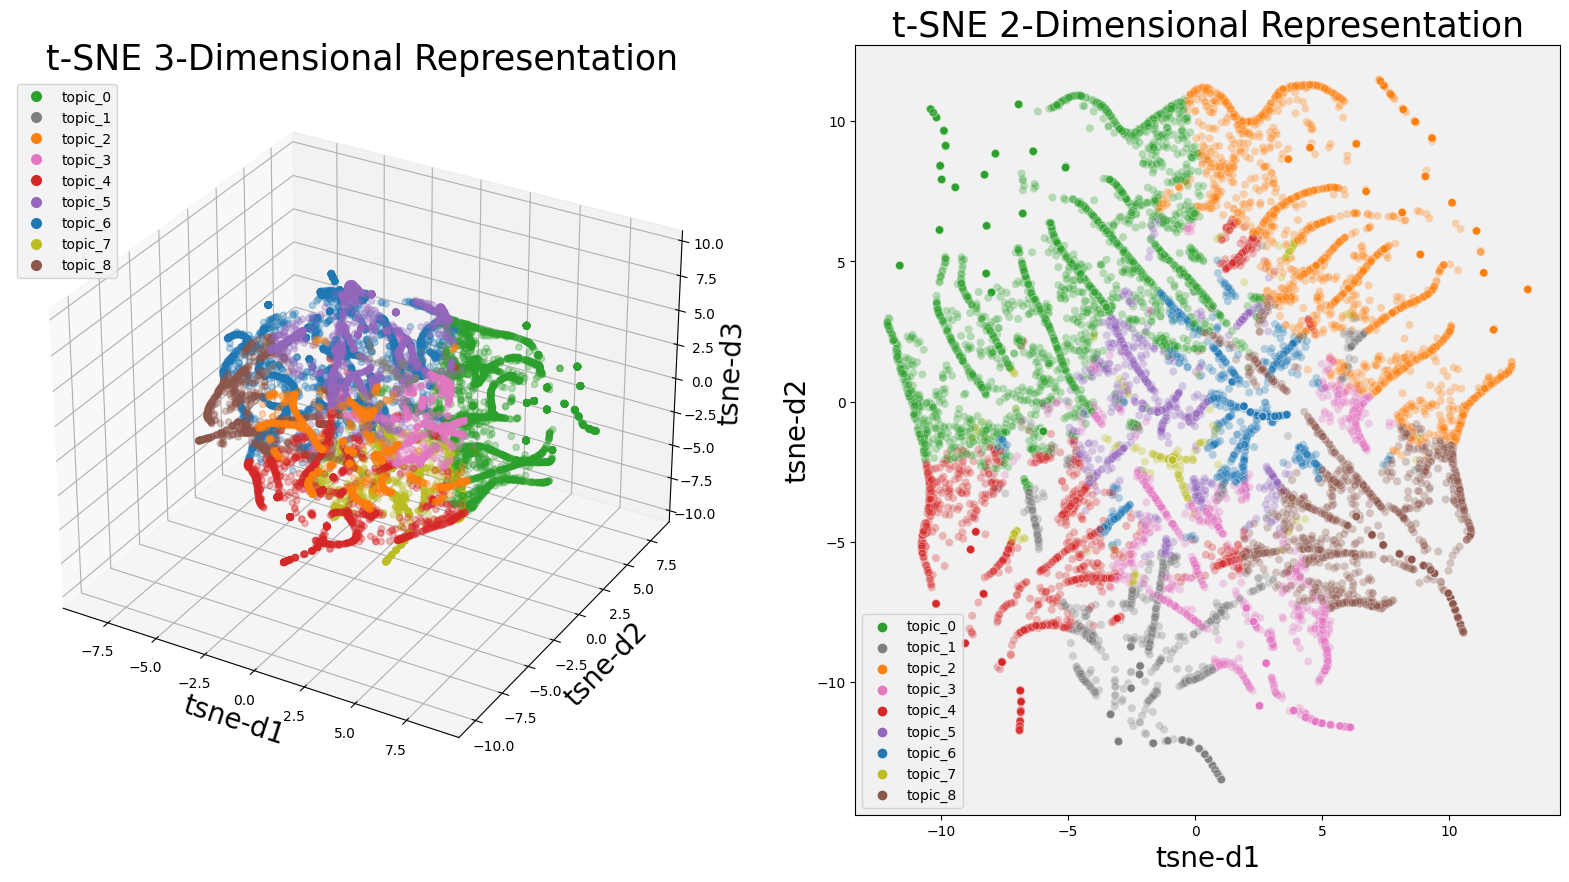

In [ ]:
LDA_tSNE_topics_vis(dimension='both',
                    dirichlet_model=lda_model,
                    corpus=corpus,
                    remove_3d_outliers=False,
                    save_png=False)

### Optimal Topic Numbers

In [ ]:
def model_coherence_generator(corpus, dictionary, data, start_topic, end_topic, step, passes):
    models = []
    coherence_scores = []
    for num in tqdm(range(start_topic, end_topic+1, step)):
        ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num, passes=passes, random_state=42)
        cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()

        coherence_scores.append(score)
        models.append(ldamodel)
    return models, coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Get the coherence scores by varing the number of topics from 2 to 40 with step=2
lda_models, coherence_scores = model_coherence_generator(corpus, dictionary, df['Tokens'], start_topic=2, end_topic=40, step=2, passes=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20/20 [14:49<00:00, 44.46s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


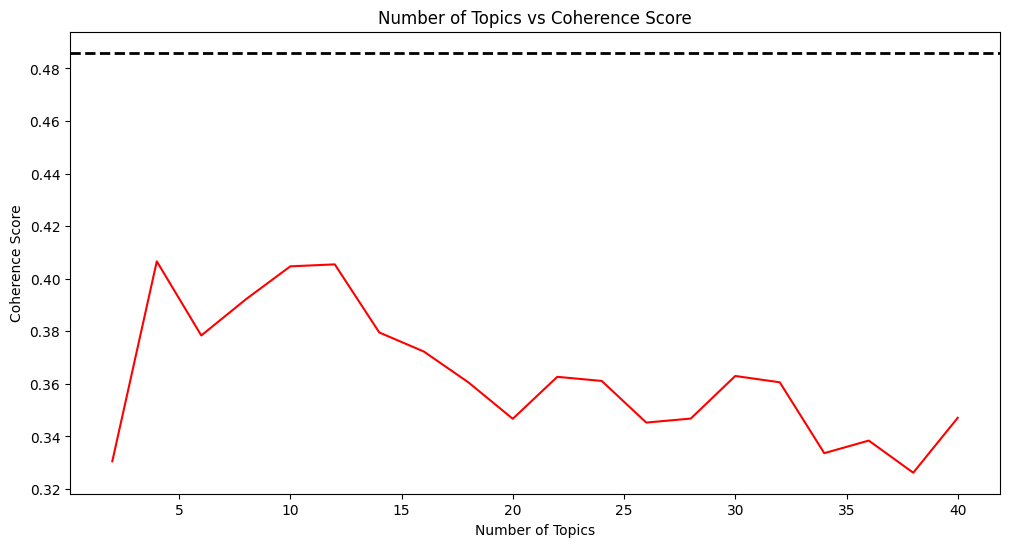

In [ ]:
#Plot the number of topics vs coherence score
x_ax = range(2, 41, 2)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.486, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

As seen in the above plot, the coherence score increases rapidly till 10 topics (coherence score = 0.486) and then starts to follow almost a horizontal trajectory, achieved the highest score at 18 topics(coherence_score=0.502).
Therefore for this corpus 10 topics and 18 topics seem like potential good options.

In [ ]:
coherence_scores[4],coherence_scores[6]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.4047250161365274, 0.3795603001749471)

In [ ]:
#save the lda_model with 10 topics
lda_4 = lda_models[1]
lda_10=lda_models[4]
lda_12 = lda_models[5]
# lda_10.save('lda_10')
# lda_18.save('lda_18')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
#save the model
pickle.dump(lda_10, open('ldamodel_t10.pkl', 'wb'))
pickle.dump(lda_18, open('ldaModel_t18.pkl', 'wb'))

In [ ]:
#load model
lda_10 = LdaModel.load('LDA_MODEL/lda_10')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data_10 = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

In [ ]:
pyLDAvis.display(vis_data_10)

In 18 topics, many topics are actually overlapped with each other, thus 10 topics LDA model was chosen for further interpretation of the topic names.

### Hyperparameter Tuning: Topic Numbers, Alpha, Beta

In [ ]:
# supporting function
def model_coherence_generator(corpus, dictionary, data, num_topics, a, b, passes):
        ldamodel = LdaModel(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics,
                            alpha=a,
                            eta=b,
                            random_state=42,
                            passes=passes)

        cv_coherence_model = CoherenceModel(model=ldamodel, corpus=corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()
        return score

In [ ]:
from google.colab import files

# Topics range
min_topics = 2
max_topics = 21
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter: 0.01, 0.31, 0.61, 0.91, 'symmetric'
# beta = [0.61]
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)), position=0, leave=True)
    # iterate through number of topics
    for b in beta:
      # iterate through alpha values
      for a in alpha:
        # iterare through beta values
        for k in topics_range:
          # get the coherence score for the given parameters
          cv = model_coherence_generator(corpus=corpus, dictionary=dictionary, data=df['Tokens'],
                                        num_topics=k, a=a, b=b, passes=passes)
          # Save the model results
          model_results['Topics'].append(k)
          model_results['Alpha'].append(a)
          model_results['Beta'].append(b)
          model_results['Coherence'].append(cv)

          pbar.update(1)
      pd.DataFrame(model_results).to_csv(str(b)+'_lda_tuning_results.csv', index=False)
      files.download(str(b)+'_lda_tuning_results.csv')
    pbar.close()

 20%|██        | 114/570 [41:19<3:01:21, 23.86s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 40%|████      | 228/570 [1:24:22<2:14:11, 23.54s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 60%|██████    | 342/570 [2:08:28<1:35:26, 25.12s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 80%|████████  | 456/570 [2:54:25<49:42, 26.16s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 570/570 [3:34:55<00:00, 22.46s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 570/570 [3:34:55<00:00, 22.62s/it]


### Plot coherence score

In [ ]:
df = df[(df['Alpha']=='asymmetric') & (df['Beta']=='0.91')]

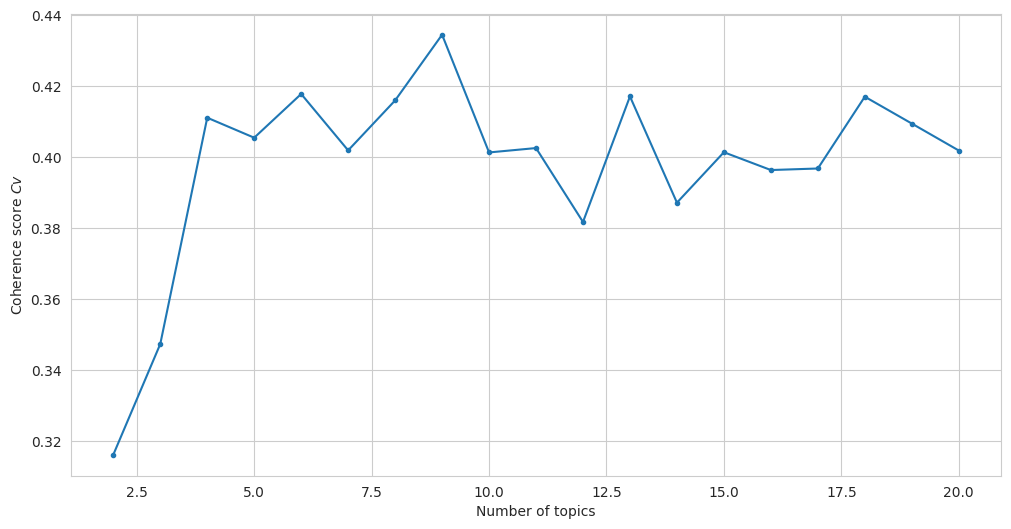

In [ ]:
dates = df['Topics']
closing_price = df['Coherence']

# Create a line plot
plt.figure(figsize=(12,6))
plt.plot(dates, closing_price, marker='.')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score $\it{Cv}$')

# Show the plot
plt.show()

### Optimal Iteration

In [ ]:
#Iterate LdaModel model over varing passes
def model_coherence_generator_2(corpus, dictionary, data, passes):
    ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=passes, random_state=42)
    cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
    score = cv_coherence_model.get_coherence()
    return ldamodel, score

#models = []
#coherence_scores = []
for passes in tqdm([1, 5, 10, 20, 40, 60, 80, 100]):
    model, score = model_coherence_generator_2(corpus, dictionary, df['Tokens'], passes)
    models.append(model)
    coherence_scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [33:38<00:00, 2018.38s/it]


In [ ]:
coherence_scores

[0.35615270842476654,
 0.4501174224234517,
 0.464733110474457,
 0.46918701431023235,
 0.47237584246599207,
 0.47387202498558506,
 0.4699180781373288,
 0.473581311212426]

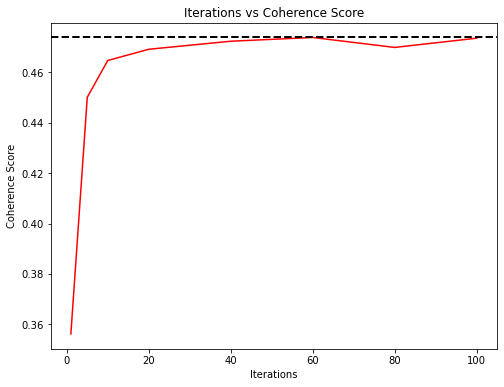

In [ ]:
#Plot the iteration times vs coherence score
x_ax = [1, 5, 10, 20, 40, 60, 80, 100]
y_ax = coherence_scores
plt.figure(figsize=(8, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y= 0.474, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Iterations vs Coherence Score')
xl = plt.xlabel('Iterations')
yl = plt.ylabel('Coherence Score')
plt.show()

Based on the plot, the coherence score increases rapidly with passes increases and achieved the highest score with passes=60.
Therefore, for the further topics extration, we will run LDA with topic_numbers=10, passes=60.

In [ ]:
lda_t10_p60 = models[6]

In [ ]:
lda_10_60 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=60, random_state=42)
cv_coherence_model = CoherenceModel(model=lda_10_60, corpus = corpus, coherence='c_v', texts=df["Tokens"])
score = cv_coherence_model.get_coherence()
print(score)

0.48034246939196856


In [ ]:
lda_10_60.save('lda_10_p60')

In [ ]:
import pickle

In [ ]:
lda_10_60 = LdaModel.load('D:/DATA_SCIENCE/Project/CHATGPT/LDA_MODEL/lda_10_p60')

In [ ]:
pprint(lda_10_60.show_topics())

[(0,
  '0.028*"use" + 0.017*"build" + 0.016*"free" + 0.014*"make" + 0.011*"pay" + '
  '0.010*"app" + 0.010*"user" + 0.010*"openai" + 0.010*"version" + '
  '0.009*"open"'),
 (1,
  '0.108*"write" + 0.049*"use" + 0.036*"ask" + 0.025*"content" + '
  '0.022*"prompt" + 0.019*"generate" + 0.019*"create" + 0.014*"thread" + '
  '0.013*"article" + 0.013*"tweet"'),
 (2,
  '0.014*"ask" + 0.012*"love" + 0.011*"talk" + 0.010*"game" + 0.008*"play" + '
  '0.008*"new" + 0.007*"story" + 0.007*"world" + 0.007*"friend" + 0.007*"let"'),
 (3,
  '0.092*"google" + 0.066*"openai" + 0.035*"search" + 0.030*"microsoft" + '
  '0.028*"chatbot" + 0.021*"gpt" + 0.017*"openais" + 0.013*"via" + 0.013*"new" '
  '+ 0.012*"company"'),
 (4,
  '0.025*"ask" + 0.024*"like" + 0.020*"know" + 0.020*"answer" + 0.017*"think" '
  '+ 0.017*"say" + 0.017*"question" + 0.013*"make" + 0.013*"would" + '
  '0.012*"get"'),
 (5,
  '0.042*"year" + 0.027*"next" + 0.024*"day" + 0.021*"week" + 0.020*"take" + '
  '0.019*"time" + 0.016*"last" + 0

In [ ]:
pprint(lda_10.show_topics())

[(0,
  '0.061*"use" + 0.042*"code" + 0.024*"write" + 0.012*"help" + 0.012*"prompt" '
  '+ 0.011*"create" + 0.011*"build" + 0.011*"video" + 0.009*"learn" + '
  '0.009*"cod"'),
 (1,
  '0.022*"day" + 0.019*"twitter" + 0.015*"year" + 0.013*"week" + 0.013*"free" '
  '+ 0.012*"get" + 0.011*"last" + 0.010*"time" + 0.009*"take" + 0.009*"pay"'),
 (2,
  '0.042*"openai" + 0.026*"new" + 0.024*"technology" + 0.023*"tech" + '
  '0.020*"chatbot" + 0.017*"future" + 0.015*"via" + 0.013*"world" + '
  '0.013*"change" + 0.012*"artificial_intelligence"'),
 (3,
  '0.037*"use" + 0.031*"content" + 0.027*"generate" + 0.026*"create" + '
  '0.021*"tool" + 0.017*"text" + 0.016*"write" + 0.016*"make" + 0.013*"help" + '
  '0.012*"idea"'),
 (4,
  '0.022*"like" + 0.018*"think" + 0.018*"get" + 0.017*"know" + 0.017*"good" + '
  '0.017*"use" + 0.016*"thing" + 0.013*"people" + 0.012*"dont" + 0.012*"try"'),
 (5,
  '0.111*"google" + 0.042*"search" + 0.013*"search_engine" + 0.012*"microsoft" '
  '+ 0.011*"replace" + 0.010*"

In [ ]:
vis_data_10_60 = pyLDAvis.gensim.prepare(lda_10_60, corpus, dictionary)

D:\software\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.display(vis_data_10_60)

# Identification of Topics

In [ ]:
import pickle
lda_model = LdaModel.load('ldamodel.pkl')

In [33]:
#get the topic distribution for each tweets
topic_dist = [lda_model[doc] for doc in corpus]

In [34]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

In [35]:
#Create a dataframe to show dominant topic for each tweet
df_topic = df[['Tweet','Tokens','date','sentiment']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic.head()

,Tweet,Tokens,date,sentiment,Dominant_Topic,Contribution%
3,Are you struggling with your cybersecurity ess...,"[struggle, cybersecurity, essay, professional,...",2023-06-10 11:53:56+00:00,2,4,59.48
5,I am delighted to share a brief talk by Prof Y...,"[delighted, share, brief, talk, prof, yves, ba...",2023-06-10 09:37:03+00:00,2,1,87.06
8,Check out this amazing video testimonial from ...,"[check, amaze, video, testimonial, one, esteem...",2023-06-10 08:00:32+00:00,2,1,66.94
10,Had a Wonderful time teaching community teache...,"[wonderful, time, teach, community, teacher, l...",2023-06-10 06:04:10+00:00,2,2,83.02
11,(asking for a friend) Are there any beginner a...,"[ask, friend, beginner, advance, course, relat...",2023-06-10 06:02:37+00:00,1,6,78.93


In [36]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Tweet':'count'}).copy().reset_index()
df_topic_summary.rename(columns={'Tweet':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,1,2393,29.19
1,3,1503,18.33
2,4,1271,15.50
3,6,1195,14.58
4,2,1041,12.70
5,5,795,9.70


In [37]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==8].sort_values('Contribution%', ascending=False)[0:10]
#df_topic[df_topic['Dominant_Topic']==6].sort_values('Contribution%', ascending=False).to_csv('topic6.csv', index=False)

,Tweet,Tokens,date,sentiment,Dominant_Topic,Contribution%


In [39]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets
#names = {1:"General Use in School",
#        2:"Ability to Pass Exams",
#        3:"Invitation to Join Events",
#        4:"Impact of ChatGPT",
#        5:"Students' Use for Assignments",
#        6:"Evaluating Response Accuracy",
#        7:"Academic Integrity",
#        8:"Anecdotal Story",
#        9:"Policy and Social Concerns"
#        }

names = {1:"Impact of ChatGPT",
        2:"Teaching Students with ChatGPT",
        3:"Controversial Issues",
        4:"Students' Use in Academic Writing",
        5:"Ability to Pass Exams",
        6:"Anecdotal Story",
        }

In [40]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)

In [41]:
df_topic

,Tweet,Tokens,date,sentiment,Dominant_Topic,Contribution%,Topic_Name
3,Are you struggling with your cybersecurity ess...,"[struggle, cybersecurity, essay, professional,...",2023-06-10 11:53:56+00:00,2,4,59.48,Students' Use in Academic Writing
5,I am delighted to share a brief talk by Prof Y...,"[delighted, share, brief, talk, prof, yves, ba...",2023-06-10 09:37:03+00:00,2,1,87.06,Impact of ChatGPT
8,Check out this amazing video testimonial from ...,"[check, amaze, video, testimonial, one, esteem...",2023-06-10 08:00:32+00:00,2,1,66.94,Impact of ChatGPT
10,Had a Wonderful time teaching community teache...,"[wonderful, time, teach, community, teacher, l...",2023-06-10 06:04:10+00:00,2,2,83.02,Teaching Students with ChatGPT
11,(asking for a friend) Are there any beginner a...,"[ask, friend, beginner, advance, course, relat...",2023-06-10 06:02:37+00:00,1,6,78.93,Anecdotal Story
...,...,...,...,...,...,...,...
13332,pov: you’re a college professor grading papers...,"[pov, youre, college, professor, grade, paper,...",2022-12-05 18:00:44+00:00,1,4,52.29,Students' Use in Academic Writing
13333,"#ChatGPT is a huge breakthrough, but I am wond...","[huge, breakthrough, wonder, create, monolith,...",2022-12-05 17:58:56+00:00,1,3,66.81,Controversial Issues
13334,Well today I get to speak with some Georgetown...,"[well, today, get, speak, georgetown, student,...",2022-12-05 17:55:44+00:00,2,1,48.72,Impact of ChatGPT
13337,A new student - #ChatGPT - decided to join my ...,"[new, student, decide, join, research, method,...",2022-12-05 17:15:52+00:00,1,4,54.64,Students' Use in Academic Writing


### Plot topic count over time

In [ ]:
from datetime import datetime

tmp = df_topic[['date', 'Topic_Name']]
tmp['date'] = pd.to_datetime(tmp['date'])

<ipython-input-79-106f0a5f3bbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['date'] = pd.to_datetime(tmp['date'])


In [ ]:
#tmp['year_week'] = tmp.date.dt.strftime('%Y-%W')
tmp['year_week'] = tmp.date.dt.strftime('%Y-%U')
tmp['month_year'] = tmp.date.dt.strftime('%b %Y')

<ipython-input-80-ba426cc47dbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['year_week'] = tmp.date.dt.strftime('%Y-%U')
<ipython-input-80-ba426cc47dbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['month_year'] = tmp.date.dt.strftime('%b %Y')


In [ ]:
tmp2 = tmp[['year_week', 'Topic_Name', 'month_year']]
tmp = tmp[['year_week', 'Topic_Name']]

In [ ]:
# reset_index() gives a column for counting, after groupby uses year and category
ctdf = (tmp.reset_index()
          .groupby(['year_week','Topic_Name'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

In [ ]:
def getMonth(year_week):
    """Return the month number in the given week in the given year."""
    year = int(year_week[:4])
    week = int(year_week[5:])
    return datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w")

ctdf['month_year'] = ctdf['year_week'].apply(getMonth)
ctdf['month_year'] = pd.to_datetime(ctdf['month_year']).dt.strftime('%b %Y')

In [ ]:
from pandas import DataFrame, concat

#line = DataFrame({"year_week": "2022-50", 'Topic_Name': 'Anecdotal Story', "ct": 13, "month_year": 'Dec 2022'}, index=[3])
#ctdf = concat([ctdf.iloc[:3], line, ctdf.iloc[3:]]).reset_index(drop=True)

#line = DataFrame({"year_week": "2023-00", 'Topic_Name': 'Anecdotal Story', "ct": 6, "month_year": 'Dec 2022'}, index=[3])
#ctdf = concat([ctdf.iloc[:30], line, ctdf.iloc[30:]]).reset_index(drop=True)

line = DataFrame({"year_week": "2023-12", 'Topic_Name': 'Anecdotal Story', "ct": 7.5, "month_year": 'Mar 2023'}, index=[3])
ctdf = concat([ctdf.iloc[:3], line, ctdf.iloc[3:]]).reset_index(drop=True)

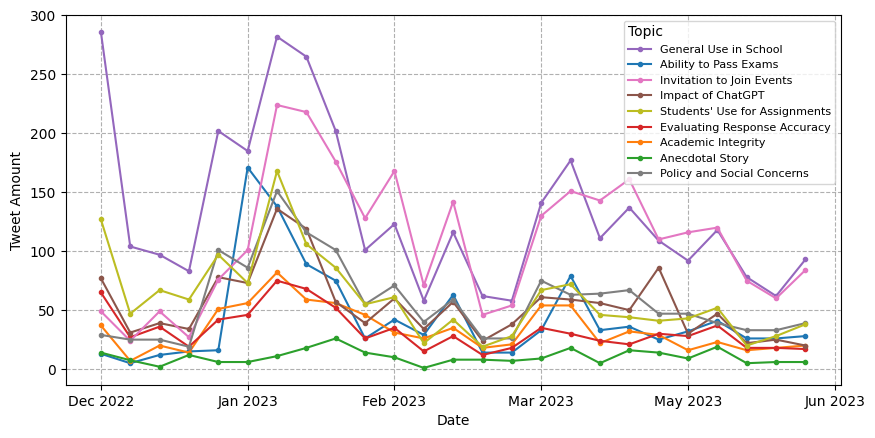

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_figwidth(10)

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('Topic_Name'):
    data.plot(x='year_week', y='ct', marker='.', ax=ax, label=key)

str_month_list = ['padding','Dec 2022','Jan 2023','Feb 2023','Mar 2023','May 2023','Jun 2023','padding']
ax.set_xticklabels(str_month_list)

plt.xlabel('Date')
plt.ylabel('Tweet Amount')
plt.grid(linestyle='--')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [4,0,6,5,8,3,1,2,7]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           title='Topic', bbox_to_anchor=(1, 1), fontsize="8", title_fontsize="10",
           loc='upper right')._legend_box.align = "left"

### Plot words per topic

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df['Tokens'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word], i+1])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count', 'topic_name_id'])

In [ ]:
df['topic_name'] = df['topic_name_id'].map(names)

<ipython-input-95-3e6fe1a81356>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


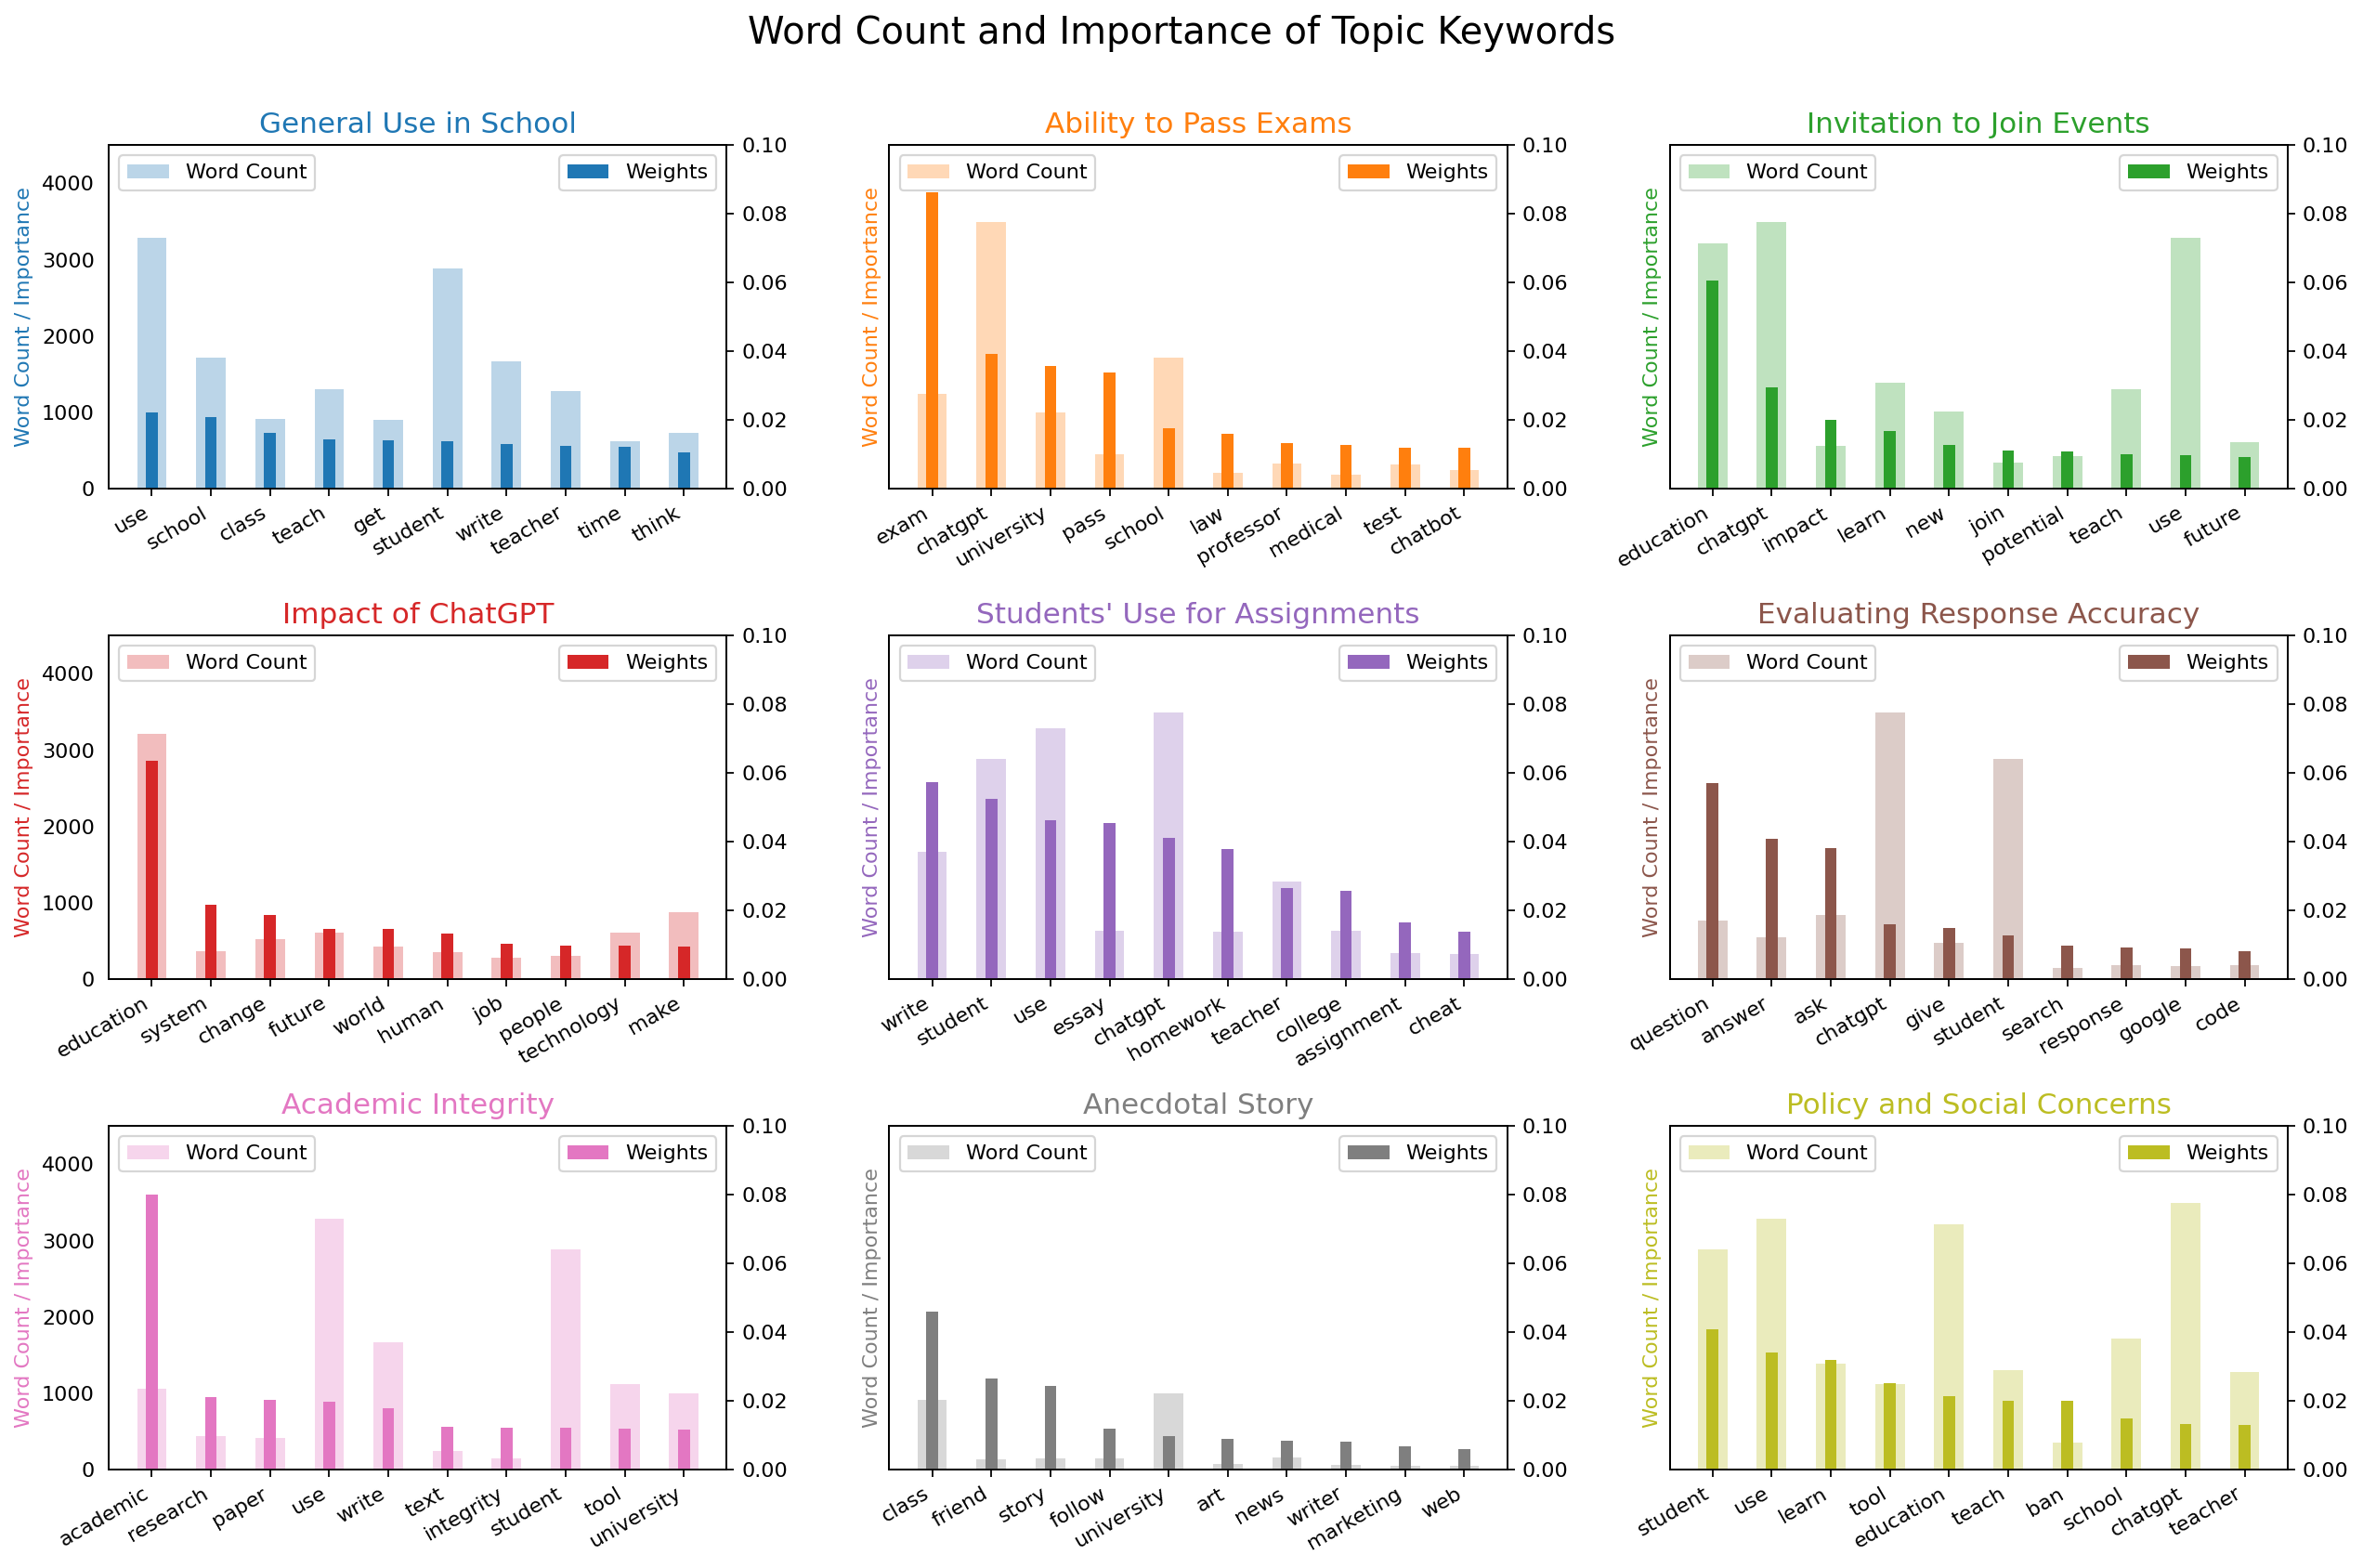

In [ ]:
import matplotlib.colors as mcolors

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count / Importance', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 4500)
    ax.set_title(df[df['topic_id']==i]['topic_name'].iloc[0], color=cols[i], fontsize=14)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05)
plt.show()

# Not Used

In [ ]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets
names = {1:"T1 ChatGPT's Cost and Access",
        2:"T2 Content and Ideas Generation",
        3:"T3 Entertainment and Activities",
        4:"T4 Competition of AI Giants",
        5:"T5 ChatGTP's Issues and Reliability",
        6:"T6 Developments and Milestones of ChatGPT",
        7:"T7 Impacts on Future Business and Industry",
        8:"T8 Impacts on Work and Efficiency",
        9:"T9 Impacts on Education and Academy",
        10:"T10 Natural Language Processing"
        }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)
df_topic.to_csv('Twitter_topics.csv', index=False)

In [ ]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, weight in lda_10_60.show_topic(n,topn=20)] for n in range(0,lda_10_60.num_topics)]

In [ ]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(),
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_10_60.num_topics+1)])
# apply style to align content to the left
topic_df

,Topic_Name,Topic_Terms
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create"
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get"
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best"
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment"
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong"
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release"
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry"
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much"
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment"
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like"


In [ ]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Tweet_count'] = df_temp['Total_tweet'].values
topic_df

,Topic_Name,Topic_Terms,Tweet_count
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create",98785
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get",88008
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best",54211
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment",55814
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong",148989
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release",30163
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry",71654
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much",154146
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment",44713
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like",86441


D:\software\Anaconda\lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


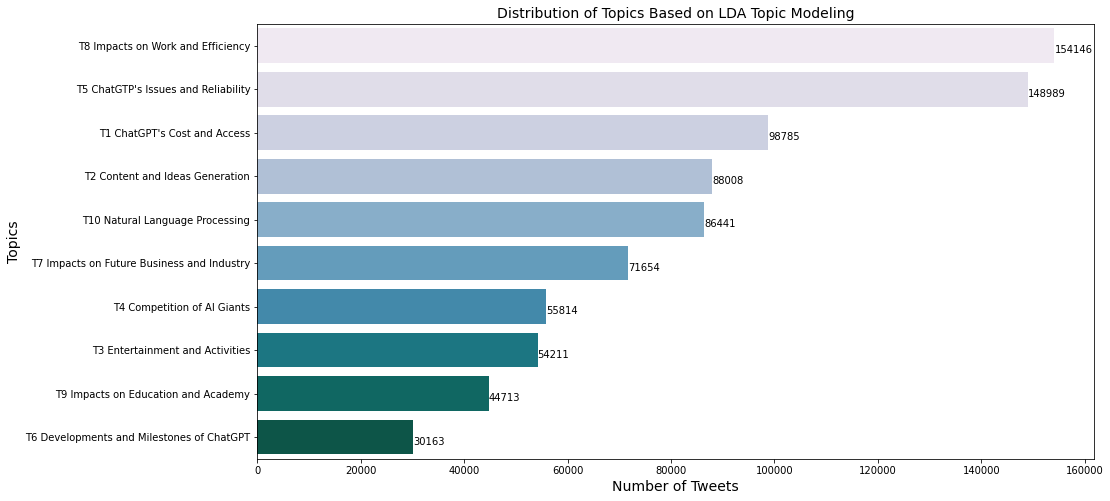

In [ ]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Tweet_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Tweet_count'], order=sort_name, palette='PuBuGn')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=14)
ax.set_xlabel('Number of Tweets', size=14)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=14)

plt.show()

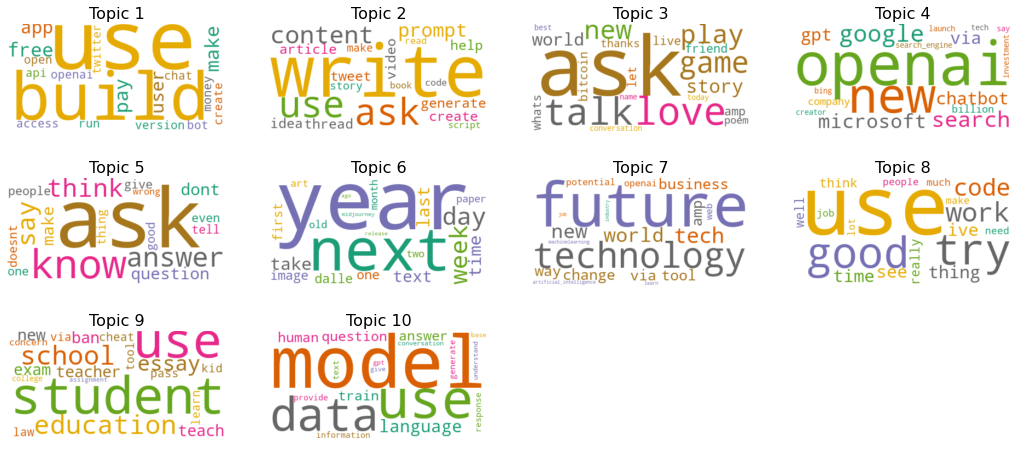

In [ ]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<10:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()
